# Importing the Dependencies

In [1]:
#Importing the required Dependencies
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

# Downloading the Dataset

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip

In [2]:
annotation_file = "/content/gdrive/My Drive/image_captioning/annotations/captions_train2014.json"

In [ ]:
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip

In [3]:
image_folder = './train2014/'

#Preprocessing

In [4]:
with open(annotation_file,'r') as f:
  annotations = json.load(f)

#Storing captions and Image names in vectors

all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
  caption = '<start> '+annot['caption']+' <end>'
  image_id = annot['image_id']
  full_coco_image_path = image_folder+"COCO_train2014_"+'%012d.jpg' % (image_id)
  all_img_name_vector.append(full_coco_image_path)
  all_captions.append(caption)

#Shuffling captions anf image names

train_captions,img_name_vectors = shuffle(all_captions,all_img_name_vector,
                                            random_state = 1)

train_captions = train_captions[:30000]
img_name_vectors = img_name_vectors[:30000]

In [5]:
print(len(train_captions),len(all_captions))

30000 414113


In [6]:
def load_image(file_path):
  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img,channels=3)
  img = tf.image.resize(img,(299,299))
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  #file_path = "./Pickle"+file_path[11:]
  print(file_path)
  return img,file_path

In [7]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input,hidden_layer)

In [8]:
#Get unique Images
encode_train = sorted(set(img_name_vectors))

#Creating the Bottle Neck Features and saving it using pickle
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image,num_parallel_calls = 
                                  tf.data.experimental.AUTOTUNE).batch(64)

for img,path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0],-1,batch_features.shape[3]))
  for bf,p in zip(batch_features,path):
      temp = p.numpy().decode("utf-8")
      temp = "./Pickle"+temp[11:]
      path_of_feature = temp
      np.save(path_of_feature,bf.numpy())

Tensor("args_0:0", shape=(), dtype=string)


In [ ]:
#In case, to delete the Pickle folder
!rm -r Pickle

## Preprocessing the captions

In [8]:
def calc_max_length(tensor):
  return max(len(t) for t in tensor )

In [9]:
top_k = 9000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token='<unk>',
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [10]:
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [11]:
#Splitting the data into training and testing
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vectors,cap_vector,
                                                                    test_size=0.001,
                                                                    random_state=0)

In [12]:
BATCH_SIZE = 64
BUFFER_SIZE=1000
embedding_dim = 256
units=512
vocab_size = top_k+1
num_steps = len(img_name_train) // BATCH_SIZE
'''Shape of the vector extracted from InceptionV3 is (64, 2048)'''
features_shape = 2048
attention_features_shape = 64

In [13]:
#Load the numpy files
def map_func(image_name,cap):
  img_tensor = np.load(image_name.decode('utf-8')+'.npy')
  return img_tensor,cap

## Creating Tensorflow Dataset Object

In [14]:
for i,name in enumerate(img_name_train):
      img_name_train[i] = "./Pickle"+name[11:]

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train,cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
                      map_func,[item1,item2],[tf.float32,tf.int32]),              
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [16]:
#To ensure that our dataset has been created
a,b = next(iter(dataset))

# Creating the Model

In [17]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self,units):
    super(BahdanauAttention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V1 = tf.keras.layers.Dense(1)

  def call(self,features,hidden):
    hidden_with_time_axis = tf.expand_dims(hidden,1)
    score = tf.nn.tanh(self.W1(hidden_with_time_axis)+
                       self.W2(features))
    attention_weights = tf.nn.softmax(self.V1(score),axis=1)


    context_vector = attention_weights*features
    context_vector = tf.reduce_sum(context_vector,axis=1)
    return context_vector,attention_weights

In [18]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self,embedding_dim):
    super(CNN_Encoder,self).__init__()
    self.fc = tf.keras.layers.Dense(embedding_dim)

  def call(self,x):
    x = self.fc(x)
    x = tf.nn.tanh(x)
    return x

In [19]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self,embedding_dim,units,vocab_size):
    super(RNN_Decoder,self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.GRU = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer = 'glorot_uniform')
    self.drop1 = tf.keras.layers.Dropout(0.4)
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.fc1 = tf.keras.layers.Dense(512)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.units)

  def call(self,x,features,hidden):
    context_vector,attention_weights = self.attention(features,hidden)
    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)

    output,state = self.GRU(x)
    x = self.fc1(output)
    x = self.drop1(x)
    x = self.batch_norm(x)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x,state,attention_weights

  def reset_state(self,batch_sz):
    return tf.zeros([batch_sz,self.units])

In [20]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim,units,vocab_size)

In [21]:
#Loss and Optimizer
optimizer=tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,reduction='none')

def loss_function(real,pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

To restore the saved weights we hve to initialize the custom Models first

In [31]:
#Initializing using Random Input
test_x = encoder(np.ones([1,64,2048]))
encoder.load_weights("/content/gdrive/My Drive/image_captioning/weights1.hdf5")
b = decoder.attention(test_x,decoder.reset_state(BATCH_SIZE))
c = decoder(tf.expand_dims([tokenizer.word_index['<start>']]*BATCH_SIZE,1),test_x,decoder.reset_state(BATCH_SIZE))
decoder.load_weights("/content/gdrive/My Drive/image_captioning/weights2.hdf5")
decoder.attention.load_weights("/content/gdrive/My Drive/image_captioning/weights3.hdf5")

Weights for this model can be downloaded from :-

[encoder](https://drive.google.com/file/d/10kEzsnO9jggFoilJpNojFWxNqZyuyIk6/view?usp=sharing)....[decoder](https://drive.google.com/file/d/16c96A8lrJ3H9IC7sfs1rZ7-vh6hmaJMp/view?usp=sharing)....
....[attetion](https://drive.google.com/file/d/1-8qgXKYmNO8knd1gESNrz62FGDPIYBs-/view?usp=sharing)

In [22]:
#In case we need to store the model as checkpoint
ckpt_path = "/content/gdrive/My Drive/model_checkpoint_3/"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt,ckpt_path,max_to_keep=3)
ckpt.restore(ckpt_manager.latest_checkpoint)
if ckpt_manager.latest_checkpoint:
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from /content/gdrive/My Drive/model_checkpoint_3/ckpt-31


In [23]:
#To plot attention
loss_plot = []

# Training

In [24]:
def train_step(img_tensor,target):
  loss = 0
  hidden = decoder.reset_state(batch_sz=target.shape[0])
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']]*target.shape[0],1)

  with tf.GradientTape() as tape:
    features = encoder(img_tensor)
    for i in range(target.shape[1]):
      prediction,hidden,_ = decoder(dec_input,features,hidden)
      loss += loss_function(target[:,i],prediction)
      dec_input = tf.expand_dims(target[:,i],1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables+decoder.trainable_variables
  gradients = tape.gradient(loss,trainable_variables)
  optimizer.apply_gradients(zip(gradients,trainable_variables))
  return loss, total_loss

In [ ]:
EPOCHS = 20
for epoch in range(EPOCHS):
  start = time.time()
  total_loss = 0
  for (batch,(img_tensor,target)) in enumerate(dataset):
    batch_loss, t_loss = train_step(img_tensor,target)
    total_loss += t_loss
    if batch%100 == 0:
        print("Epoch:{}.....Batch:{}.....Loss:{}".format(epoch+1,
                                                         batch,batch_loss.numpy() / int(target.shape[1])))
    
    loss_plot.append(total_loss/num_steps)
  if epoch%1==0:
      ckpt_manager.save()
      encoder.save_weights("/content/gdrive/My Drive/image_captioning/weights1.hdf5",overwrite=True)
      decoder.attention.save_weights("/content/gdrive/My Drive/image_captioning/weights3.hdf5",overwrite=True)
      decoder.save_weights("/content/gdrive/My Drive/image_captioning/weights2.hdf5",overwrite=True)
  print('Epcoh:{}...................Loss:{}'.format(epoch+1,total_loss/num_steps))
  print("Time Taken __ {:.3f} sec".format(time.time()-start))

#Evaluate the Model

In [28]:
def evaluate(image):
  attention_plot = np.zeros([max_length,attention_features_shape])
  hidden = decoder.reset_state(1)
  temp_input = tf.expand_dims(load_image(image)[0], 0)
  img_tensor_val = image_features_extract_model(temp_input)
  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

  features = encoder(img_tensor_val)
  dec_input = tf.expand_dims([tokenizer.word_index['<start>']],0)
  result = []
  for i in range(max_length):
    prediction,hidden,attention_weights = decoder(dec_input,features,hidden)
    attention_plot[i] = tf.reshape(attention_weights,(-1,)).numpy()
    predicted_id = tf.random.categorical(prediction,1)[0][0].numpy()
    result.append(tokenizer.index_word[predicted_id])
    if tokenizer.index_word[predicted_id] == '<end>':
        return result, attention_plot
    dec_input = tf.expand_dims([predicted_id],0)
  
  attention_plot = attention_plot[:len(result),:]
  return result,attention_plot

In [26]:
def plot_attention(image,result,attention_plot):
  temp_image = np.array(Image.open(image))
  fig = plt.figure(figsize=(15,15))
  len_result = len(result)
  for i in range(len_result):
    temp_att = np.resize(attention_plot[i],(8,8))
    ax =fig.add_subplot(len_result//2, len_result//2, i+1)
    ax.set_title(result[i])
    img = ax.imshow(temp_image)
    ax.imshow(temp_att,cmap='gray',alpha=0.6,extent=img.get_extent())

  #plt.tight_layout()
  plt.show()

./train2014/COCO_train2014_000000417594.jpg
Real Caption: <start> a couple of giraffes are standing by a rock wall <end>
Prediction Caption: <start> a group of giraffes are standing by itself in an open field <end>


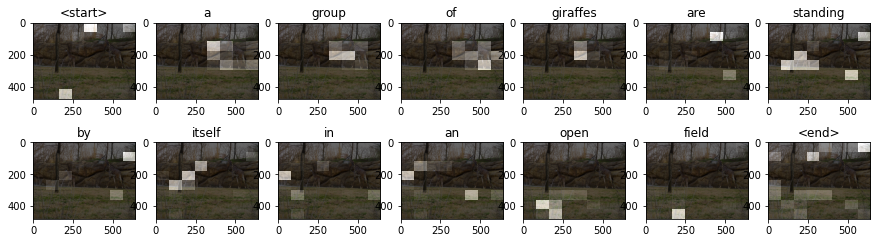

In [60]:
rid = np.random.randint(0,len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result,attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

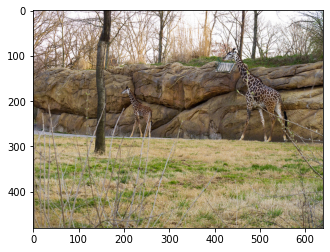

In [61]:
plt.imshow(np.array(Image.open(img_name_val[rid])))

**We can also generate multiple captions for one Image.**

./train2014/COCO_train2014_000000453332.jpg
Real Caption: <start> two black and white clocks a tan building and a white and blue bus <end>
Prediction Caption: <start> a bus parked in a city street <end>


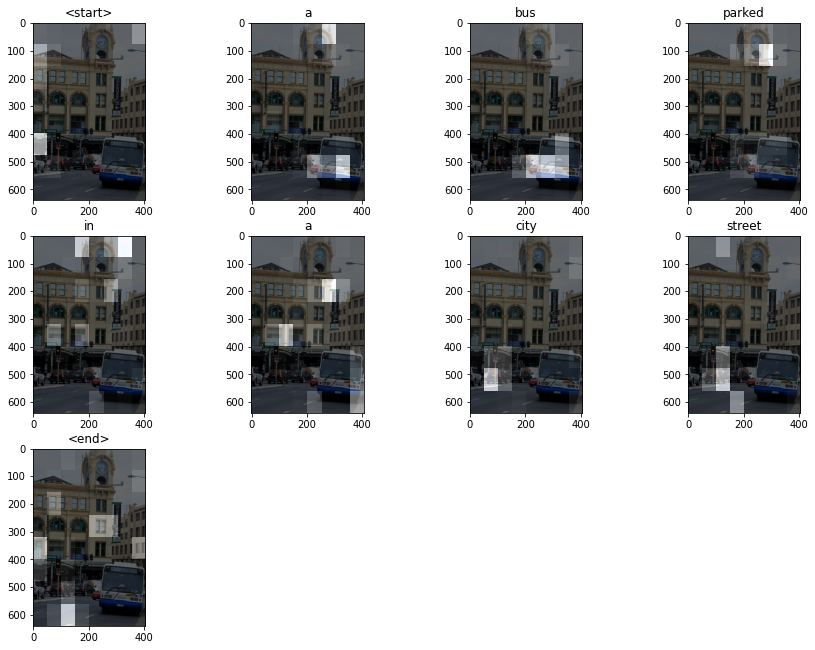

In [65]:
rid = np.random.randint(0,len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result,attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

./train2014/COCO_train2014_000000453332.jpg
Real Caption: <start> two black and white clocks a tan building and a white and blue bus <end>
Prediction Caption: <start> a bus is in the street near a building <end>


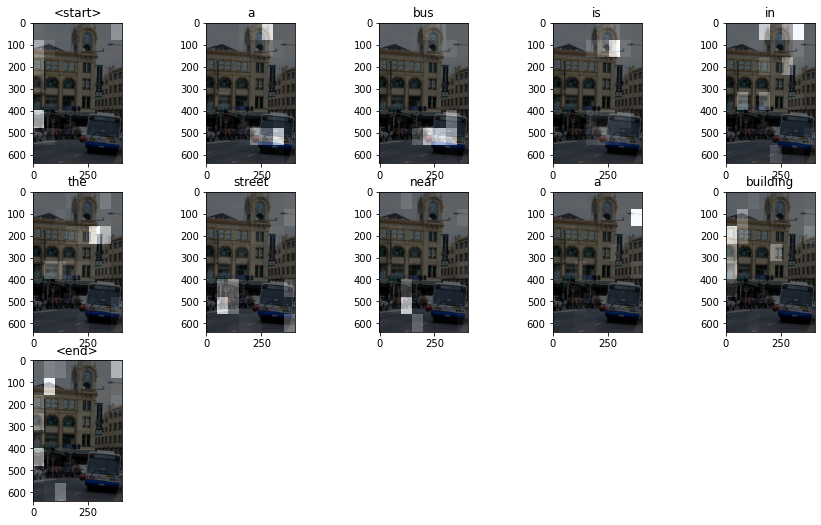

In [74]:
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result,attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

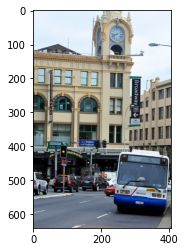

In [73]:
plt.imshow(np.array(Image.open(img_name_val[rid])))